In [199]:
import warnings
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

from mmcv.runner import load_checkpoint
from mmdet.core import get_classes
from mmdet.models import build_detector
from mmdet.apis import inference_detector
from mmcv import Config

# 필요한 기능 정의

In [200]:
def init_detector(config, checkpoint=None, device='cuda:0', cfg_options=None):
    """Initialize a detector from config file.

    Args:
        config (str, :obj:`Path`, or :obj:`mmcv.Config`): Config file path,
            :obj:`Path`, or the config object.
        checkpoint (str, optional): Checkpoint path. If left as None, the model
            will not load any weights.
        cfg_options (dict): Options to override some settings in the used
            config.

    Returns:
        nn.Module: The constructed detector.
    """
    # if isinstance(config, (str, Path)):
    #     config = mmcv.Config.fromfile(config)
    # elif not isinstance(config, mmcv.Config):
    #     raise TypeError('config must be a filename or Config object, '
    #                     f'but got {type(config)}')
    if cfg_options is not None:
        config.merge_from_dict(cfg_options)
    if 'pretrained' in config.model:
        config.model.pretrained = None
    elif 'init_cfg' in config.model.backbone:
        config.model.backbone.init_cfg = None
    config.model.train_cfg = None
    model = build_detector(config.model, test_cfg=config.get('test_cfg'))
    if checkpoint is not None:
        checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')
        if 'CLASSES' in checkpoint.get('meta', {}):
            model.CLASSES = checkpoint['meta']['CLASSES']
        else:
            warnings.simplefilter('once')
            warnings.warn('Class names are not saved in the checkpoint\'s '
                          'meta data, use COCO classes by default.')
            model.CLASSES = get_classes('coco')
    model.cfg = config  # save the config in the model for convenience
    model.to(device)
    model.eval()
    return model

In [201]:
def show_result_gt(img_path, df, class_names, colors):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.copy()
    for i in range(len(df)):
        line = df.iloc[i]
        x_min, y_min, x_max, y_max = map(int, [line['x_min'], line['y_min'], line['x_max'], line['y_max']])
        class_name = class_names[int(line['label'])]
        color = colors[int(line['label'])]
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 3)
        text_size, _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        text_x = text_size[0]
        text_y = text_size[1]
        img = cv2.rectangle(img, (x_min, y_min), (x_min + text_size[0], y_min + text_y), (0,0,0), -1)
        img = cv2.putText(img, class_name, (x_min, y_min + text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return img

In [202]:
def show_result_pred(img_path, results, class_names, colors, score_thr=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.copy()
    for result in results:
        for idx, res in enumerate(result):
            score = res[4]
            if score_thr < score:
                x_min, y_min, x_max, y_max = map(int, res[:4])
                class_name = class_names[idx]
                color = colors[idx]
                img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 3)
                text_size, _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
                text_x = text_size[0]
                text_y = text_size[1]
                img = cv2.rectangle(img, (x_min, y_min), (x_min + text_size[0], y_min + text_y), (0,0,0), -1)
                img = cv2.putText(img, class_name, (x_min, y_min + text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return img

# Ground Truth bbox를 위해 dataset 불러오기

In [203]:
from pycocotools.coco import COCO
import pandas as pd

# Dataset
class Dataset:
    def __init__(self, data_dir="../../../dataset", json_file="train.json"):
        """
        annotation: annotation 파일 위치
        data_dir: data가 존재하는 폴더 경로
        category_id: ["General trash", "Paper", "Paper pack", "Metal", "Glass",
                        "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
        """

        super().__init__()
        self.data_dir = data_dir
        self.annotation = os.path.join(self.data_dir, json_file)

        info = []
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(self.annotation)
        for image_id in self.coco.getImgIds():
            image_info = self.coco.loadImgs(image_id)[0]
            annotation_id = self.coco.getAnnIds(imgIds=image_info["id"])
            annotation_info_list = self.coco.loadAnns(annotation_id)

            file_name = os.path.join(self.data_dir, image_info["file_name"])

            # [x_min, x_max, y_min, y_max]
            for annotation in annotation_info_list:
                info.append(
                    [
                        image_id,
                        file_name,
                        int(annotation["category_id"]),
                        float(annotation["bbox"][0]),
                        float(annotation["bbox"][0]) + float(annotation["bbox"][2]),
                        float(annotation["bbox"][1]),
                        (float(annotation["bbox"][1]) + float(annotation["bbox"][3])),
                        float(annotation["bbox"][2]),
                        float(annotation["bbox"][3]),
                        float(annotation["area"]),
                    ]
                )

        self.df = pd.DataFrame(
            info,
            columns=[
                "img_id",
                "img_path",
                "label",
                "x_min",
                "x_max",
                "y_min",
                "y_max",
                "width",
                "height",
                "area",
            ],
        )

        self.df["center_x"] = (self.df["x_max"] + self.df["x_min"]) / 2
        self.df["center_y"] = (self.df["y_max"] + self.df["y_min"]) / 2
        
        
    def grouping_bbox_per_img(self):
        """
        Using Example:
            eda = EDADataset()
            img_df, img_df_idx = eda.grouping_bbox_per_img()
            eda.df.iloc[img_df_idx[1]] -> 하나의 이미지에 있는 bbox의 정보를 나타냄
        Return:
            Return group index (dict type)
        """
        group_df = self.df.groupby("img_id")
        return group_df, group_df.groups

# 필요한 정보들 정의

In [204]:
config_path = '../[model]FasterRCNN_V3/FasterRCNN_V3_config.py'
checkpoint_path = '../[model]FasterRCNN_V3/checkpoint/latest.pth'

In [205]:
cfg = Config.fromfile(config_path)

data_root = '../../../../../../dataset/'

cfg.data.train.dataset.img_prefix = data_root
cfg.data.train.dataset.ann_file = os.path.join(data_root, 'train2_swj.json')
cfg.data.val.img_prefix = data_root
cfg.data.val.ann_file = os.path.join(data_root, 'val2_swj.json')
cfg.data.test.img_prefix = data_root
cfg.data.test.ann_file = os.path.join(data_root, 'val2_swj.json')

In [206]:
model = init_detector(cfg, checkpoint=checkpoint_path)

load checkpoint from local path: ../[model]FasterRCNN_V3/checkpoint/latest.pth


In [207]:
dataset = Dataset(data_dir=data_root, json_file='val2_swj.json')
df = dataset.df
_, img_df_idx = dataset.grouping_bbox_per_img()

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


# Class와 class에 따른 색깔 정의

In [208]:
class_names = [
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",]
colors = [(251, 76, 81),
          (251, 76, 195),
          (158, 76, 251),
          (76, 97, 251),
          (76, 190, 251),
          (76, 251, 217),
          (76, 251, 126),
          (251, 251, 76),
          (251, 195, 76),
          (251, 129, 76)]

# Bounding box 비교하기

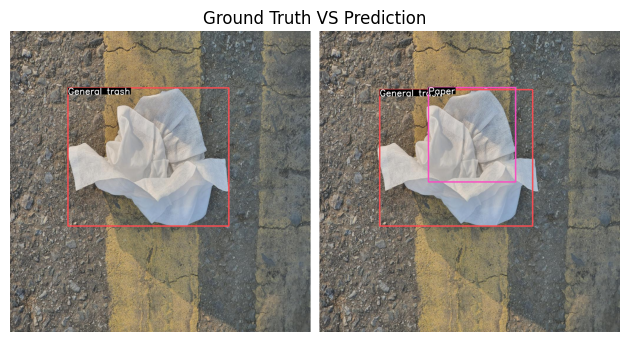

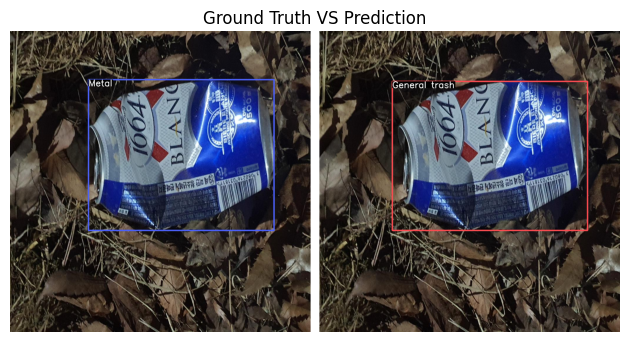

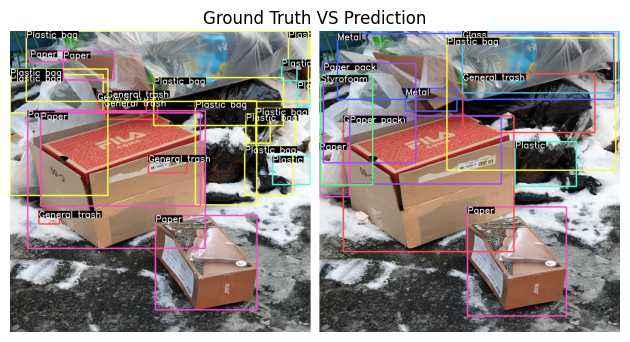

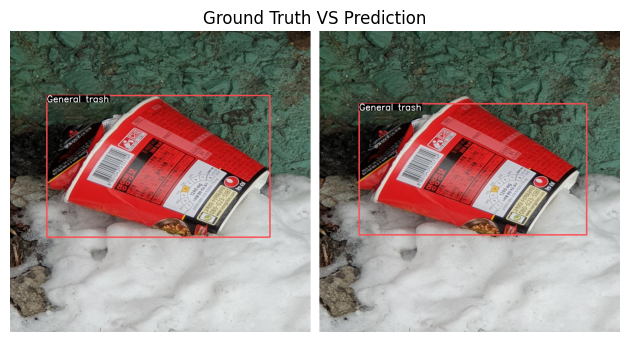

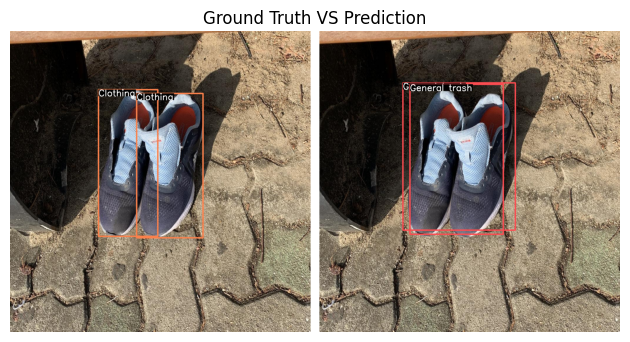

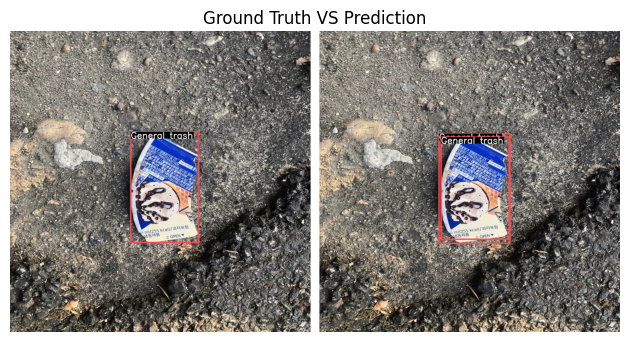

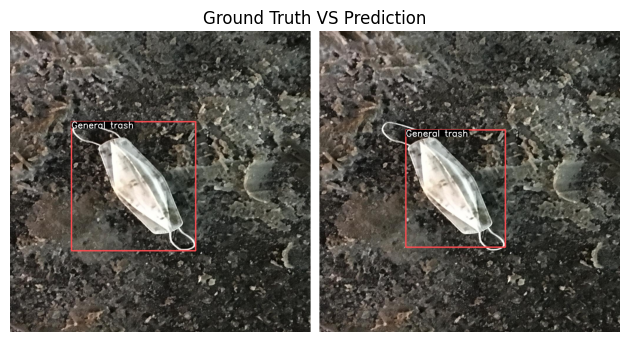

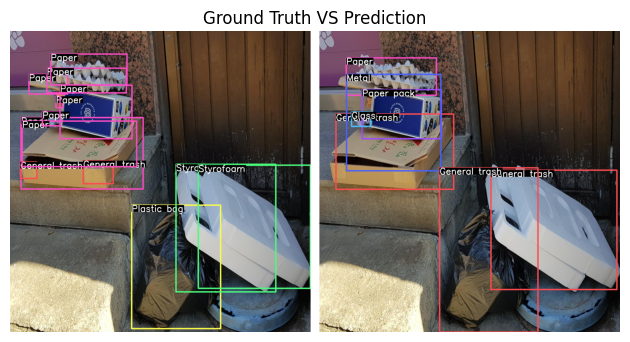

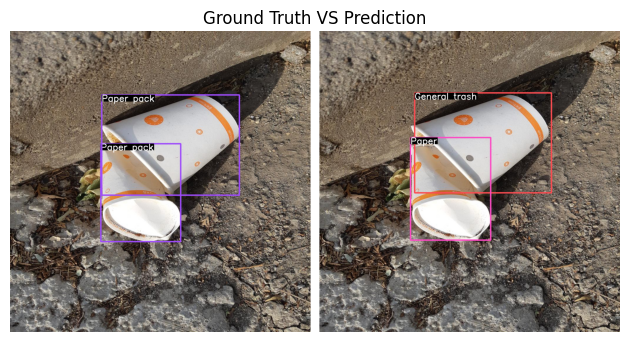

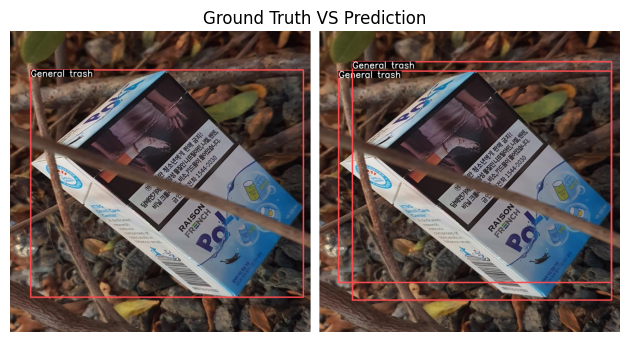

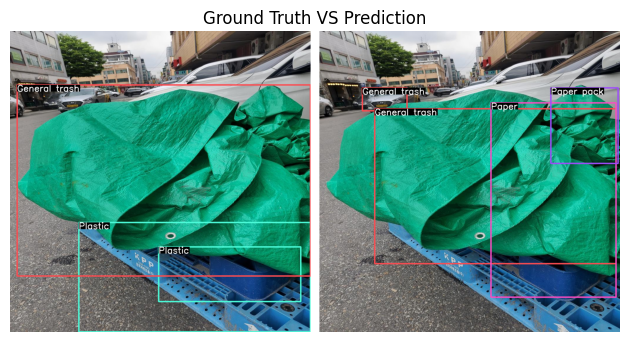

In [211]:
idx = 0
for key in img_df_idx:
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    result_pred = inference_detector(model, img_path)
    img_pred = show_result_pred(img_path, result_pred, class_names, colors, score_thr=0.5)
    img_gt = show_result_gt(img_path, img_df, class_names, colors)
    line = np.ones((1024,30,3), dtype='uint8')*255
    img = np.concatenate((img_gt, line, img_pred), axis=1)
    plt.imshow(img)
    plt.title('Ground Truth VS Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    if idx == 10:
        break
    idx += 1